Compare the risks of ``used_cars`` dataset

In [4]:
from matplotlib import pyplot as plt
from random import random

def compare_used_cars(dataset_name, location='../experiment_output_exhaustive/', max_risk=1, repeat=1, col=10, 
            max_length=30, title=None):
    test_risks={}
    train_risks={}
    and_counts={}
    aucs={}
    file_numbers={}
    desc=dataset_name
    max_risk=get_max_risk(dataset_name)
    print(max_risk)
    objs = ['gpe','orth']
    for obj in objs:
        algos = ['fc'] if obj=='orth' else ['boosting'] if obj=='gpe' else ['keep']
        for algo in algos:
            methods = ['Newton-CG'] if algo=='fc' else ['']
            for method in methods:
                done = True
                fc_train=[0]*10
                fc_test=[0]*10
                ands = [0]*10
                file_number=0
                for i in range(repeat):
                    filename = dataset_name + '_' + obj + '_' + algo + '_' + method + '_realkd_col_' + \
                        str(col) + '_rep' + str(1) + '.txt'
                    try:
                        f = open(location+'/'+dataset_name+'/'+filename, 'r')
                        file_number+=1
                    except:
                        print(obj, algo, method,'does not exist: ')
                        print(location+'/'+dataset_name+'/'+filename)
                        continue
                    j=-1
                    for line in f:
                        if 'iteration ' in line:
                            j+=1
                        if j>=10:
                            break
                        words=line.split(' ')
                        if 'fc train risk' in line:
                            fc_train[j] += float(words[-1])
                        elif 'fc test risk' in line:
                            fc_test[j] += float(words[-1])
                        if 'if' in line:
                            ands[j]+=line.count('=')+1
                if done:
                    file_numbers[obj + '_' + algo + '_' + method] = file_number
                    train_risks[obj + '_' + algo + '_' + method]=fc_train
                    test_risks[obj + '_' + algo + '_' + method]=fc_test
                    and_counts[obj + '_' + algo + '_' + method]=ands
                    if file_number==0:
                        continue
                    print(obj + '_' + algo + '_' + method+': avg train risk:',sum(fc_train)/10/max_risk/file_number, 
                          'avg test risk', sum(fc_test)/10/max_risk/file_number, '&s:', sum(ands)/10/file_number)

    rg=list(range(1,11))
    plt.figure(figsize=(7.5,5.5))
    colours = {}
    line_width = {}
    width = [1,1, 1, 1]*4
    i = 0
    colors=['green','red','gold','deepskyblue','violet','cyan','brown','deepskyblue','purple', 'lime',
            'slategray','magenta','pink','olive','khaki']
    label_map={'gpe_boosting_':'GB / XGBoost', 'gpe_fc_Newton-CG': 'Gradient Fully-corrective Boosting', 
               'orth_fc_Newton-CG': 'FCOGB', 'xgb_keep_': 'XGBoost', 
              'xgb_fc_Newton-CG': 'XG Fully-corrective Boosting'}
    for item in train_risks:
        color = colors[i]
        colours[item] = color
        line_width[item] = width[i]
        i+=1
        if file_numbers[item]==0:
            continue
        train_risks[item] = [risk / max_risk/file_numbers[item] for risk in train_risks[item]]
        test_risks[item] = [risk / max_risk/file_numbers[item] for risk in test_risks[item]]
        and_counts[item] = [ands / file_numbers[item] for ands in and_counts[item]]
        aucs[item] = and_counts[item][0]+sum((train_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                                   min(max_length, and_counts[item][m]))
                                for m in range(len(train_risks[item])-1))
        print(item, 'auc:', aucs[item])
        print(and_counts[item], train_risks[item])
        plt.step([0]+and_counts[item], [1]+train_risks[item], '--', color=colours[item],
                 linewidth=line_width[item],where='post')
        plt.step([0]+and_counts[item], [1]+test_risks[item], color=colours[item],
                 label=label_map[item]+ '',linewidth=line_width[item],where='post')
    plt.xlabel('Cognitive Complexity', fontsize=12)
    plt.xlim(0,30)
    plt.ylabel('Risk', fontsize=12)
    plt.yscale('log')
    boosting_rule='''Gradient Boosting:
 +17933.38 if PS>=120 & year>=2005
 +7090.75  if km<=125000 & year>=2011
 - 8206.32  if 120<=PS<=160 & year>=2005
 +2401.70  if True
 - 4397.03  if 120<=PS<=220 & 2005<=year<=2011
 +4585.17  if count<=69 & km>=50000 & PS>=160 
              & year<=2005'''
    orth_rule = '''Proposed algorithm:
 +7303.87  if year>=2005
 +6138.81  if count<=149 & PS>=160
 +10100.84 if PS>=120 & year>=2011
 +5744.60  if PS>=220 & year>=2000'''
    plt.annotate('', xy=(21.2, 0.080), xytext=(22, 0.26), fontsize=12, arrowprops=dict(facecolor='black', width=0.2, shrink=0.05))
    plt.annotate('', xy=(11, 0.09), xytext=(4.7, 0.071), fontsize=12,arrowprops=dict(facecolor='black', width=0.2, shrink=0.05))
    
    plt.ylim(0.025, 1.35)
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    plt.text(7.8,0.25, boosting_rule, bbox=bbox_props, fontsize=11)
    plt.text(1,0.031, orth_rule, bbox=bbox_props, fontsize=11)
    plt.grid(visible=True, which='major')
    plt.grid(visible=True, which='minor')
    plt.gca().set_ylim(bottom=0)
    plt.legend()
    plt.savefig('used_cars_compare.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    return train_risks, test_risks, and_counts, aucs

def get_max_risk(dataset_name):
    d = {'gdp': 43.986571428571416,
        'wage': 2029057842.6515312,
        'titanic': 1.0,
        'insurance': 322646873.58870494,
        'used_cars': 194464336.77843493,
        'tic_tac_toe': 1.0,
        'boston': 592.1469169960473,
        'world_happiness_indicator': 30.46778212179487,
        'Demographics': 31.64835409252669,
        'IBM_HR': 1.0, 'telco_churn': 1.0,
        'mobile_prices': 3.5,
        'GenderRecognition': 1.0,
        'breast_cancer': 1.0,
        'load_diabetes': 29074.481900452487,
        'iris': 1.0,
        'load_wine': 1.0,
         'suicide_rates_cleaned': 523.7783290690134,
         'videogamesales': 2.70680865164444,
         'digits5': 1.0,
         'red_wine_quality': 32.41651031894934, 
         'banknote': 1.0, 
         'liver': 1.0, 
         'magic': 1.0, 
         'adult': 1.0,
         'who_life_expectancy': 4882.764241803283,
         'vaccine': 228506505.50612897, 
         'ships': 12.342277392898044, 
         'smoking': 7.500299349437478, 
         'covid_vic': 51.62076805721374, 
         'covid_world': 14143.401514056353, 
         'covid': 1082.8170359400497, 
         'bicycle': 1076.416963882381, 
         'austin-water': 3975.767978495398,
         'make_friedman2': 379683.4049960418, 
         'make_friedman3': 1.8780821278399789, 
         'make_friedman1': 226.89125115757616
        }
    return 1

1
194464336.77843493
gpe_boosting_: avg train risk: 0.11487454540713478 avg test risk 0.12722486528807636 &s: 19.7
orth_fc_Newton-CG: avg train risk: 0.10029036859594534 avg test risk 0.11924908580687092 &s: 15.9
gpe_boosting_ auc: 6.457178249636495
[3.0, 6.0, 10.0, 11.0, 16.0, 21.0, 25.0, 30.0, 35.0, 40.0] [0.2645509110573421, 0.2022870824853723, 0.14187958375417029, 0.11221783977219958, 0.0916455280655313, 0.08210179754828802, 0.07295471467740056, 0.0644309787818688, 0.06023299339480931, 0.056444024534365776]
orth_fc_Newton-CG auc: 4.939863596764699
[2.0, 5.0, 8.0, 11.0, 15.0, 17.0, 20.0, 24.0, 27.0, 30.0] [0.30332439036990055, 0.1618711977941554, 0.10198183908872074, 0.08398049183450944, 0.0736811325954079, 0.06703474590169989, 0.060176481642162445, 0.05434522178694212, 0.05006708428097964, 0.0464411006649755]


<ipython-input-32-34dbbc10f67f>:115: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.gca().set_ylim(bottom=0)


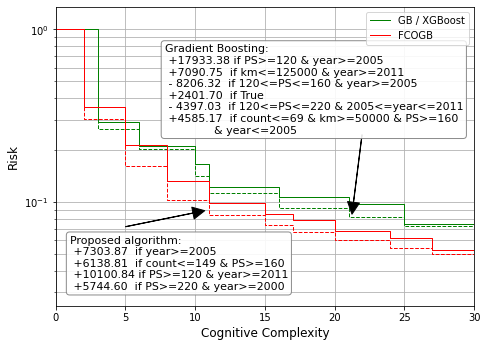

In [34]:
datasets = ['used_cars']

values = ['gpe_boosting_', 
               'orth_fc_Newton-CG']
print(len(datasets))
cols = [10, 10, 10, 5, 10, 3, 10, 4, 10, 10, 10,
       2, 20, 10, 5, 4, 10, 10, 10, 10, 10, 
       10, 10, 10, 10]
max_components = [30] * len(datasets)
f = open("../experiment_output_exhaustive/compare_used_cars.csv", 'w')
f.write('dataset'+(','+','.join(values))*4+'\n')
for i in range(len(datasets)):
        max_risk = get_max_risk(datasets[i])
        train, test, ands, aucs = compare_used_cars(datasets[i], col=cols[i], max_length=max_components[i])
        f.write(datasets[i] + ',')
        for value in values:
            f.write(str(sum(train[value]))+',')
        for value in values:
            f.write(str(sum(test[value]))+',')
        for value in values:
            f.write(str(max(ands[value]))+',')
        for value in values:
            f.write(str(aucs[value])+',')
        f.write('\n')


Compare risks of gradient sum (mwg), gradient boosting (gpe), XGBoost (xgb) and FCOGB (orth)

In [17]:
from matplotlib import pyplot as plt
from random import random

def compare_risks(dataset_name, location='../experiment_output_20230421_', max_risk=1, repeat=5, col=10, 
            max_length=30, title=None):
    test_risks={}
    train_risks={}
    and_counts={}
    aucs_test={}
    aucs_train={}
    file_numbers={}
    desc=dataset_name
    max_risk=get_max_risk(dataset_name)
    print(max_risk)
    objs = ['mwg','gpe','xgb','orth']
    for obj in objs:
        algos = ['fc'] if obj=='orth' else ['boosting'] if obj in ['gpe', 'mwg'] else ['keep']
        search = 'exhaustive' if obj in ['xgb', 'orth'] else 'greedy'
        for algo in algos:
            methods = ['Newton-CG'] if algo=='fc' else ['']
            for method in methods:
                done = True
                fc_train=[0]*30
                fc_test=[0]*30
                ands = [0]*30
                file_number=0
                for i in range(repeat):
                    filename = dataset_name + '_' + obj + '_' + algo + '_' + method + '_realkd_col_' + \
                        str(col) + '_rep' + str(i) + '.txt'
                    try:
                        f = open(location+search+''+'/'+dataset_name+'/'+filename, 'r')
                        file_number+=1
                    except:
#                         print(obj, algo, method,'does not exist: ')
#                         print(location+'/'+dataset_name+'/'+filename)
                        continue
                    j=-1
                    for line in f:
                        if 'iteration' in line:
                            j+=1
                        if j>=30:
                            break
                        words=line.split(' ')
                        if 'train score' in line:
                            fc_train[j] += float(words[-1])
                        elif 'test score' in line:
                            fc_test[j] += float(words[-1])
                        if 'if' in line:
                            ands[j]+=line.count('=')+1
#                             print(line, ands[j])
                if done:
                    file_numbers[obj + '_' + algo + '_' + method] = file_number
                    train_risks[obj + '_' + algo + '_' + method]=fc_train
                    test_risks[obj + '_' + algo + '_' + method]=fc_test
                    and_counts[obj + '_' + algo + '_' + method]=ands
                    if file_number==0:
                        continue
                    print(obj + '_' + algo + '_' + method+': avg train risk:',sum(fc_train)/10/max_risk/file_number, 
                          'avg test risk', sum(fc_test)/10/max_risk/file_number, '&s:', sum(ands)/10/file_number)

#     rg=list(range(1,11))
    plt.figure(figsize=(8,6))
    colours = {}
    line_width = {}
    width = [1,1, 1, 1]*4
    i = 0
    colors=['blue','green','red','gold','deepskyblue','violet','cyan','brown','deepskyblue','purple', 'lime',
            'slategray','magenta','pink','olive','khaki']
    label_map={'gpe_boosting_':'Gradient Boosting', 'gpe_fc_Newton-CG': 'Gradient Fully-corrective Boosting', 
               'orth_fc_Newton-CG': 'Orthogonal Fully-corrective Boosting', 'xgb_keep_': 'XGBoost', 
              'xgb_fc_Newton-CG': 'XG Fully-corrective Boosting',
              'mwg_boosting_': 'Gradient Descent'}
    for item in train_risks:
        color = colors[i]
        colours[item] = color
        line_width[item] = width[i]
        i+=1
        if file_numbers[item]==0:
            continue
        train_risks[item] = [risk / max_risk/file_numbers[item] for risk in train_risks[item]]
        test_risks[item] = [risk / max_risk/file_numbers[item] for risk in test_risks[item]]
        and_counts[item] = [ands / file_numbers[item] for ands in and_counts[item]]
        aucs_test[item] = sum((test_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                 min(max_length, and_counts[item][m]))
                                for m in range(0,len(test_risks[item])-1))
        aucs_train[item] = sum((train_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                 min(max_length, and_counts[item][m]))
                                for m in range(0,len(train_risks[item])-1))
        
        
#         if and_counts[item][-1]<max_length:
#             aucs_test[item]+=test_risks[item][-1]*(max_length-and_counts[item][-1])
#             aucs_train[item]+=train_risks[item][-1]*(max_length-and_counts[item][-1])
        aucs_train[item] /= max_length # min(max_length, and_counts[item][-1])
        aucs_test[item] /= max_length # min(max_length, and_counts[item][-1]) # min(max_length, and_counts[item][-1])
        print(item, 'auc:', aucs_train[item], aucs_test[item])
        print(and_counts[item], train_risks[item])
        plt.step([0]+and_counts[item], [0]+train_risks[item], '--', color=colours[item],
                 label=label_map[item],linewidth=line_width[item],where='post')
#         plt.step([0]+and_counts[item], [1]+test_risks[item], color=colours[item],
#                  label=label_map[item],linewidth=line_width[item],where='post')
    plt.title(dataset_name if title is None else title + " risks")
    plt.xlabel('number of rules')
    plt.xlim(0,max_length)
    plt.ylabel('risk')
#     plt.yscale('log')
    plt.grid(visible=True, which='major')
    plt.grid(visible=True, which='minor')
    plt.gca().set_ylim(bottom=0)
    plt.legend()
    plt.show()
    
    return train_risks, test_risks, and_counts, aucs_train, aucs_test

Calculating largest gaps between two algorithms

In [18]:
def map_size_risk(train_risks, sizes):
    risks = [1]
    szs = [0]
    sz = 0
    for i in range(len(sizes)):
        while sz<=sizes[i]:
            sz+=0.2
            szs.append(sz)
            if i==0:
                risk=1
            else:
                risk=train_risks[i-1]
            risks.append(risk)
            
    return risks, szs
def largest_gaps(train_risks, and_counts, a, b, max_size=150):
    risks_a, szs_a = map_size_risk(train_risks[a], and_counts[a])
    risks_b, szs_b = map_size_risk(train_risks[b], and_counts[b])
    max_risk_index_ab = -1000
    max_difference = -1000
    for i in range(min([len(szs_a), len(szs_b), max_size])):
        if risks_a[i]!=1 or risks_b[i]!=1:
            if risks_a[i]-risks_b[i]>max_difference:
                max_risk_index_ab=i
                max_difference = risks_a[i]-risks_b[i]
    return max_difference, szs_a[max_risk_index_ab], risks_a[max_risk_index_ab], risks_b[max_risk_index_ab]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


34
1


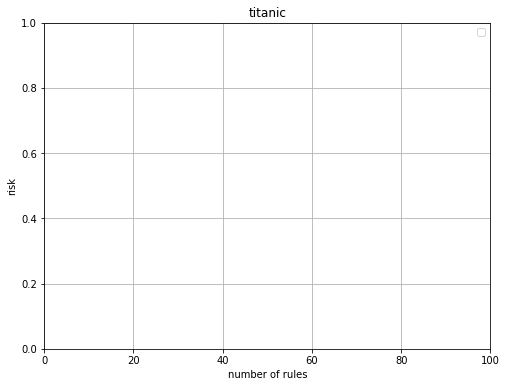

{'mwg_boosting_': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'gpe_boosting_': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'xgb_keep_': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'orth_fc_Newton-CG': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


IndexError: list index out of range

In [19]:
datasets = ['titanic','tic-tac-toe','iris','breast_cancer','load_wine',
            'IBM_HR', 'telco_churn', 'GenderRecognition',
            'banknote', 'liver', 'magic', 'adult', 'digits5',
            'insurance','make_friedman1',
            'make_friedman2','make_friedman3','wage', 'Demographics','gdp','used_cars','load_diabetes',
            'boston','world_happiness_indicator', 'who_life_expectancy', 'mobile_prices', 'suicide_rates_cleaned','videogamesales',
             'red_wine_quality',
            'covid_vic','covid',
            'bicycle','ships','smoking']

values = [
    'mwg_boosting_',
    'gpe_boosting_', 
    'xgb_keep_', 
    'orth_fc_Newton-CG']
print(len(datasets))
cols = [10, 10, 10, 5, 6, 
        3, 4, 3, 10, 10, 5, 5, 3,
        10, 4, 10, 10, 10,
       2, 20, 10, 5, 4, 10, 5, 4, 3, 3, 5,
        10, 10, 10, 10, 10]
max_components = [100] * len(datasets)
# max_components[14]=25
# max_components[15]=20
# max_components[5]=20
f = open("../analysis_results/1compare_test.csv", 'w')
f2 = open("../analysis_results/1compare_train.csv", 'w')
f.write('dataset'+(','+','.join(values))*4+'\n')
for i in range(len(datasets)):
#     try:
        max_risk = get_max_risk(datasets[i])
        train, test, ands, aucs_tr, aucs_te = compare_risks(datasets[i], col=cols[i], max_length=max_components[i])
        print(train)
        gpe_orth_test = largest_gaps(test, ands, 'gpe_boosting_', 'orth_fc_Newton-CG')
        xgb_orth_test = largest_gaps(test, ands, 'xgb_keep_', 'orth_fc_Newton-CG')
        orth_gpe_test = largest_gaps(test, ands, 'orth_fc_Newton-CG', 'gpe_boosting_')
        orth_xgb_test = largest_gaps(test, ands, 'orth_fc_Newton-CG', 'xgb_keep_')
        orth_mwg_test = largest_gaps(test, ands, 'orth_fc_Newton-CG', 'mwg_boosting_')
        mwg_orth_test = largest_gaps(test, ands, 'mwg_boosting_', 'orth_fc_Newton-CG')
        gpe_orth_train = largest_gaps(train, ands, 'gpe_boosting_', 'orth_fc_Newton-CG')
        xgb_orth_train = largest_gaps(train, ands, 'xgb_keep_', 'orth_fc_Newton-CG')
        orth_gpe_train = largest_gaps(train, ands, 'orth_fc_Newton-CG', 'gpe_boosting_')
        orth_xgb_train = largest_gaps(train, ands, 'orth_fc_Newton-CG', 'xgb_keep_')
        orth_mwg_train = largest_gaps(train, ands, 'orth_fc_Newton-CG', 'mwg_boosting_')
        mwg_orth_train = largest_gaps(train, ands, 'mwg_boosting_', 'orth_fc_Newton-CG')
        
        f.write(datasets[i] + ',')
        for value in values:
            f.write(str(max(ands[value]))+',')
        for value in values:
            f.write(str(aucs_te[value])+',')
        f.write(str(mwg_orth_test[0])+','+str(mwg_orth_test[1])+','+str(mwg_orth_test[2])+','+str(mwg_orth_test[3])+',')
        f.write(str(gpe_orth_test[0])+','+str(gpe_orth_test[1])+','+str(gpe_orth_test[2])+','+str(gpe_orth_test[3])+',')
        f.write(str(xgb_orth_test[0])+','+str(xgb_orth_test[1])+','+str(xgb_orth_test[2])+','+str(xgb_orth_test[3])+',')
        f.write(str(orth_mwg_test[0])+','+str(orth_mwg_test[1])+','+str(orth_mwg_test[2])+','+str(orth_mwg_test[3])+',')
        f.write(str(orth_gpe_test[0])+','+str(orth_gpe_test[1])+','+str(orth_gpe_test[2])+','+str(orth_gpe_test[3])+',')
        f.write(str(orth_xgb_test[0])+','+str(orth_xgb_test[1])+','+str(orth_xgb_test[2])+','+str(orth_xgb_test[3])+',')
        f.write('\n')
        
        f2.write(datasets[i] + ',')
        for value in values:
            f2.write(str(max(ands[value]))+',')
        for value in values:
            f2.write(str(aucs_tr[value])+',')
        f2.write(str(mwg_orth_train[0])+','+str(mwg_orth_train[1])+','+str(mwg_orth_train[2])+','+str(mwg_orth_train[3])+',')
        f2.write(str(gpe_orth_train[0])+','+str(gpe_orth_train[1])+','+str(gpe_orth_train[2])+','+str(gpe_orth_train[3])+',')
        f2.write(str(xgb_orth_train[0])+','+str(xgb_orth_train[1])+','+str(xgb_orth_train[2])+','+str(xgb_orth_train[3])+',')
        f2.write(str(orth_mwg_train[0])+','+str(orth_mwg_train[1])+','+str(orth_mwg_train[2])+','+str(orth_mwg_train[3])+',')
        f2.write(str(orth_gpe_train[0])+','+str(orth_gpe_train[1])+','+str(orth_gpe_train[2])+','+str(orth_gpe_train[3])+',')
        f2.write(str(orth_xgb_train[0])+','+str(orth_xgb_train[1])+','+str(orth_xgb_train[2])+','+str(orth_xgb_train[3])+',')
        f2.write('\n')

f.close()
f2.close()
print('done')

In [61]:
a=[2.0, 5.0, 11.0, 17.2, 22.2, 27.8, 34.4, 40.0, 46.2] 
b=[0.7633096371635981, 0.795342951339558, 0.8320443255036457, 0.8638467928159417, 0.8714866426073122, 0.8784415310012307, 0.8839821912541048, 0.8920352479173271, 0.8965499393314535]
ds=sum([b[i]*(a[i+1]-a[i]) for i in range(len(a)-1)])
ds / 0.8450930656178037 

44.609114719797475

Ablation study:

    GB -> FCGB -> Greedy FCOGB -> Optimal FCOGB

| dataset       | d  | n     | GS           | GB           | XGBoost  | SIRUS        | FCOGB        |
|---------------|----|-------|--------------|--------------|----------|--------------|--------------|
| titanic       | 7  | 1043  | **0.78752**  | 0.727948     | 0.7325   | 0.664431     | 0.778426     |
| tic-tac-toe   | 27 | 958   | 0.708737     | 0.716479     | 0.717067 | 0.60964      | **0.726228** |
| iris          | 4  | 150   | 0.875425     | 0.86651      | 0.839935 | 0.742919     | **0.881986** |
| breast        | 30 | 569   | **0.897696** | 0.889331     | 0.893343 | 0.791486     | 0.889429     |
| wine          | 13 | 178   | 0.894133     | 0.85058      | 0.861576 | 0.793705     | **0.912642** |
| ibm hr        | 32 | 1470  | 0.667322     | **0.67223**  | 0.632674 | 0.607837     | 0.657805     |
| telco churn   | 18 | 7043  | 0.725904     | 0.720219     | 0.722172 | 0.66231      | **0.729716** |
| gender        | 20 | 3168  | 0.486778     | 0.470553     | 0.470984 | **0.775951** | 0.470553     |
| banknote      | 4  | 1372  | **0.899631** | 0.890474     | 0.897367 | 0.753027     | 0.893664     |
| liver         | 6  | 345   | **0.685153** | 0.611111     | 0.613133 | 0.605248     | 0.646615     |
| magic         | 10 | 19020 | **0.744575** | 0.743076     | 0.744574 | 0.545998     | 0.7429       |
| adult         | 11 | 30162 | **0.791683** | 0.773234     | 0.781667 | 0.632768     | 0.78947      |
| digits5       | 64 | 3915  | 0.74688      | **0.748379** | 0.731503 | 0.296475     | 0.679976     |
| insurance     | 6  | 1338  | 0.620298     | 0.664873     | 0.659807 | 0.486541     | **0.71715**  |
| friedman1     | 10 | 2000  | 0.431334     | 0.361504     | 0.379854 | **0.437503** | 0.431486     |
| friedman2     | 4  | 10000 | 0.584721     | 0.580484     | 0.592331 | 0.488965     | **0.656538** |
| friedman3     | 4  | 5000  | 0.438531     | 0.459526     | 0.460006 | 0.388198     | **0.50676**  |
| wage          | 5  | 1379  | 0.218629     | 0.207464     | 0.222415 | 0.153447     | **0.248165** |
| demographics  | 13 | 6876  | 0.157453     | 0.16834      | 0.168314 | 0.162178     | **0.175056** |
| gdp           | 1  | 35    | 0.587244     | 0.597622     | 0.600313 | 0.432508     | **0.62943**  |
| used cars     | 4  | 1770  | 0.648908     | 0.570787     | 0.614504 | 0.50587      | **0.689341** |
| diabetes      | 10 | 442   | 0.359284     | 0.348785     | 0.345223 | 0.301056     | **0.381975** |
| boston        | 13 | 506   | 0.448998     | 0.431143     | 0.450646 | 0.474624     | **0.497284** |
| happiness     | 8  | 315   | 0.622574     | 0.616553     | 0.571129 | 0.056363     | **0.640955** |
| life expect.  | 21 | 1649  | 0.540651     | 0.497625     | 0.496597 | 0.465874     | **0.570566** |
| mobile prices | 20 | 2000  | 0.622739     | 0.657299     | 0.657617 | 0.527975     | **0.665716** |
| suicide rate  | 5  | 27820 | 0.178393     | 0.2163       | 0.216158 | 0.2066       | **0.229871** |
| videogame     | 6  | 16327 | 0.001101     | 0.001101     | 0.001101 | **0.001106** | 0.001104     |
| red wine      | 11 | 1599  | 0.226449     | 0.199057     | 0.209499 | 0.167853     | **0.232382** |
| covid_vic     | 4  | 85    | 0.697194     | 0.758415     | NA       | NA           | **0.766479** |
| covid         | 2  | 225   | 0.347911     | 0.366511     | NA       | NA           | **0.401122** |
| bicycle       | 4  | 122   | 0.582707     | 0.591599     | 0.582928 | NA           | **0.599117** |
| ships         | 4  | 34    | 0.727248     | 0.777        | NA       | NA           | **0.826615** |
| smoking       | 2  | 36    | 0.82216      | 0.842706     | 0.485595 | NA           | **0.866948** |

In [12]:
from matplotlib import pyplot as plt
from random import random

def compare4(dataset_name, max_risk=1, repeat=5, col=10, 
            max_length=30, title=None):
    test_risks={}
    train_risks={}
    and_counts={}
    aucs_test={}
    file_numbers={}
    desc=dataset_name
    max_risk=get_max_risk(dataset_name)
    print(max_risk)
    searches=['greedy', 'exhaustive']
    for search in searches:
        location='../experiment_output_20230411_'+search
        objs = ['mwg','gpe','orth']
        for obj in objs:
            algos = ['fc'] if obj=='orth' else ['boosting', 'fc'] if obj in ['gpe'] else ['keep']
            for algo in algos:
                methods = ['Newton-CG'] if algo=='fc' else ['']
                for method in methods:
                    done = True
                    fc_train=[0]*10
                    fc_test=[0]*10
                    ands = [0]*10
                    file_number=0
                    for i in range(repeat):
                        filename = dataset_name + '_' + obj + '_' + algo + '_' + method + '_realkd_col_' + \
                            str(col) + '_rep' + str(i) + '.txt'
                        try:
                            f = open(location+'/'+dataset_name+'/'+filename, 'r')
                            file_number+=1
                        except:
                            continue
                        j=-1
                        for line in f:
                            if 'iteration ' in line:
                                j+=1
                            if j>=10:
                                break
                            words=line.split(' ')
                            if 'fc train risk' in line:
                                fc_train[j] += float(words[-1])
                            elif 'fc test risk' in line:
                                fc_test[j] += float(words[-1])
                            if 'if' in line:
                                ands[j]+=line.count('=')+1
                    if done:
                        file_numbers[search+'_'+obj + '_' + algo + '_' + method] = file_number
                        train_risks[search+'_'+obj + '_' + algo + '_' + method]=fc_train
                        test_risks[search+'_'+obj + '_' + algo + '_' + method]=fc_test
                        and_counts[search+'_'+obj + '_' + algo + '_' + method]=ands
                        if file_number==0:
                            continue
                        print(obj + '_' + algo + '_' + method+': avg train risk:',sum(fc_train)/10/max_risk/file_number, 
                              'avg test risk', sum(fc_test)/10/max_risk/file_number, '&s:', sum(ands)/10/file_number)

    rg=list(range(1,11))
    plt.figure(figsize=(8,6))
    colours = {}
    line_width = {}
    width = [1,1, 1, 1]*4
    i = 0
    colors=['blue','green','red','deepskyblue','gold','violet','cyan','brown','deepskyblue','purple', 'lime',
            'slategray','magenta','pink','olive','khaki']
    label_map={'greedy_gpe_boosting_':'Gradient Boosting', 'greedy_gpe_fc_Newton-CG': 'Gradient Fully-corrective Boosting', 
               'greedy_orth_fc_Newton-CG': 'Greedy Orthogonal Fully-corrective Boosting', 'xgb_keep_': 'XGBoost', 
              'xgb_fc_Newton-CG': 'XG Fully-corrective Boosting', 'exhaustive_gpe_boosting_':'Optimal Gradient Boosting', 
               'exhaustive_gpe_fc_Newton-CG': 'Optimal Gradient Fully-corrective Boosting',
               'exhaustive_orth_fc_Newton-CG': 'Optimal Orthogonal Fully-corrective Boosting',
               'greedy_mwg_boosting_':'Gradient Descent',
               'exhaustive_mwg_boosting_': 'Optimal Gradient Descent',
               'greedy_mwg_fc_Newton-CG':'FC Gradient Descent',
               'exhaustive_mwg_fc_Newton-CG': 'Optimal FC Gradient Descent',
              }
    for item in train_risks:
        color = colors[i]
        colours[item] = color
        line_width[item] = width[i]
        i+=1
        if file_numbers[item]==0:
            continue
        train_risks[item] = [risk / max_risk/file_numbers[item] for risk in train_risks[item]]
        test_risks[item] = [risk / max_risk/file_numbers[item] for risk in test_risks[item]]
        and_counts[item] = [ands / file_numbers[item] for ands in and_counts[item]]
        aucs_test[item] = and_counts[item][0]+sum((test_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                                   min(max_length, and_counts[item][m]))
                                for m in range(len(test_risks[item])-1))
        aucs_train[item] = and_counts[item][0]+sum((train_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                                   min(max_length, and_counts[item][m]))
                                for m in range(len(train_risks[item])-1))
        if and_counts[item][-1]<max_length:
            aucs_test[item]+=test_risks[item][-1]*(max_length-and_counts[item][-1])
            aucs_train[item]+=train_risks[item][-1]*(max_length-and_counts[item][-1])
        print(item, 'auc:', aucs_test[item])
        plt.step([0]+and_counts[item], [1]+train_risks[item], '--', color=colours[item],
                 label=label_map[item],linewidth=line_width[item],where='post')
    plt.title(dataset_name if title is None else title + " risks")
    plt.xlabel('number of rules')
    plt.xlim(0,30)
    plt.ylabel('risk')
    plt.yscale('log')
    plt.grid(visible=True, which='major')
    plt.grid(visible=True, which='minor')
    plt.gca().set_ylim(bottom=0)
    plt.legend()
    
    return train_risks, test_risks, and_counts, aucs_test, aucs_train


The next three functions computes the largest gaps from one algorithm to another.

In [13]:
def map_size_risk(train_risks, sizes):
    risks = [1]
    szs = [0]
    sz = 0
    for i in range(len(sizes)):
        while sz<=sizes[i]:
            sz+=0.2
            szs.append(sz)
            if i==0:
                risk=1
            else:
                risk=train_risks[i-1]
            risks.append(risk)
    return risks, szs


def largest_gaps(train_risks, and_counts, a, b, max_size=150):
    risks_a, szs_a = map_size_risk(train_risks[a], and_counts[a])
    risks_b, szs_b = map_size_risk(train_risks[b], and_counts[b])
    max_risk_index_ab = -1000
    max_diff=-100
    for i in range(min([len(szs_a), len(szs_b), max_size])):
        if i <= 25:
            continue
        if risks_a[i]!=1 and risks_b[i]!=1:
            if risks_a[i]-risks_b[i]>max_diff:
                max_risk_index_ab=i
                max_diff = risks_a[i]-risks_b[i]
    print(max_risk_index_ab)
    print(risks_a[max_risk_index_ab], risks_b[max_risk_index_ab])
    return risks_a[max_risk_index_ab]-risks_b[max_risk_index_ab], szs_a[max_risk_index_ab], risks_a[max_risk_index_ab], risks_b[max_risk_index_ab], max_risk_index_ab


def internal_steps(train_risks, and_counts, a, b, max_risk_index_ab):
    risks_a, szs_a = map_size_risk(train_risks[a], and_counts[a])
    risks_b, szs_b = map_size_risk(train_risks[b], and_counts[b])
    return  risks_a[max_risk_index_ab]-risks_b[max_risk_index_ab], szs_a[max_risk_index_ab], risks_a[max_risk_index_ab], risks_b[max_risk_index_ab]

In [16]:
values = ['greedy_gpe_boosting_', 
          'greedy_gpe_fc_Newton-CG', 
              'greedy_orth_fc_Newton-CG', 
               'exhaustive_orth_fc_Newton-CG',
          'exhaustive_gpe_boosting_',
         ]
datasets = ['titanic','tic-tac-toe','iris','breast_cancer',
            'IBM_HR', 'telco_churn', 'GenderRecognition',
            'banknote', 'liver', 'magic', 'adult', 'digits5',
            'insurance','make_friedman1',
            'make_friedman2','make_friedman3','wage', 'Demographics','gdp','used_cars','load_diabetes',
            'boston','world_happiness_indicator', 'who_life_expectancy', 'mobile_prices', 'suicide_rates_cleaned',
            'videogamesales', 'red_wine_quality',
            'covid_vic','covid',
            'bicycle','ships','smoking']
cols = [10, 10, 10, 5, 
        3, 4, 3, 10, 10, 5, 5, 3,
        10, 4, 10, 10, 10,
       2, 20, 10, 5, 4, 10, 5, 4, 3, 3, 5,
        10, 10, 10, 10, 10]
print(len(cols))
datapoints = [891,958,150,569,178,1470, 7043, 3168, 1372, 345, 19020, 30162, 5620,
              1338,1000,5000,2000,1379,8992,35,1770,442,506,156, 2928, 2000, 27820, 16598, 1599, 
              85,225,122,34,36]

max_components = [30] * len(datasets)
max_components[11]=25
max_components[12]=25
f = open("../analysis_results/1ablation_te.csv", 'w')
f.write('dataset'+(','+','.join(values))*4+'\n')
f2 = open("../analysis_results/1ablation_tr.csv", 'w')
f2.write('dataset'+(','+','.join(values))*4+'\n')
for i in range(len(datasets)):
    try:
        print(datasets[i])
        max_risk = get_max_risk(datasets[i])
        train, test, ands, aucs_te, aucs_tr = compare4(datasets[i], col=cols[i], max_length=max_components[i])
        gpe_orth_test = largest_gaps(test, ands, 'exhaustive_gpe_boosting_', 'exhaustive_orth_fc_Newton-CG')
        orth_gpe_test = largest_gaps(test, ands, 'exhaustive_orth_fc_Newton-CG', 'exhaustive_gpe_boosting_')
        gpe_fc_test = internal_steps(test, ands, 'exhaustive_gpe_boosting_', 'greedy_gpe_fc_Newton-CG', gpe_orth[4])
        fc_gpe_test = internal_steps(test, ands, 'greedy_gpe_fc_Newton-CG', 'exhaustive_gpe_boosting_', orth_gpe_test[4])
        fc_orth_test = internal_steps(test, ands, 'greedy_gpe_fc_Newton-CG', 'greedy_orth_fc_Newton-CG', gpe_orth[4])
        orth_fc_test = internal_steps(test, ands, 'greedy_orth_fc_Newton-CG', 'greedy_gpe_fc_Newton-CG', orth_gpe_test[4])
        greedy_opt_test = internal_steps(test, ands, 'greedy_orth_fc_Newton-CG', 'exhaustive_orth_fc_Newton-CG', gpe_orth[4])
        opt_greedy_test = internal_steps(test, ands, 'exhaustive_orth_fc_Newton-CG', 'greedy_orth_fc_Newton-CG', orth_gpe_test[4])
        
        f.write(datasets[i] + ',')
        for value in values:
            f.write(str(max(ands[value]))+',')
        for value in values:
            f.write(str(aucs_te[value])+',')
        f.write(str(gpe_fc_test[0])+','+str(gpe_fc_test[1])+','+str(gpe_fc_test[2])+','+str(gpe_fc_test[3])+',')
        f.write(str(fc_gpe_test[0])+','+str(fc_gpe_test[1])+','+str(fc_gpe_test[2])+','+str(fc_gpe_test[3])+',')
        f.write(str(fc_orth_test[0])+','+str(fc_orth_test[1])+','+str(fc_orth_test[2])+','+str(fc_orth_test[3])+',')
        f.write(str(orth_fc_test[0])+','+str(orth_fc_test[1])+','+str(orth_fc_test[2])+','+str(orth_fc_test[3])+',')
        f.write(str(greedy_opt_test[0])+','+str(greedy_opt_test[1])+','+str(greedy_opt_test[2])+','+str(greedy_opt_test[3])+',')
        f.write(str(opt_greedy_test[0])+','+str(opt_greedy_test[1])+','+str(opt_greedy_test[2])+','+str(opt_greedy_test[3])+',')
        f.write(str(gpe_orth[0])+','+str(gpe_orth[1])+','+str(gpe_orth[2])+','+str(gpe_orth[3])+',')
        f.write(str(orth_gpe_test[0])+','+str(orth_gpe_test[1])+','+str(orth_gpe_test[2])+','+str(orth_gpe_test[3])+',')
        f.write('\n')
        
        gpe_orth_train = largest_gaps(train, ands, 'exhaustive_gpe_boosting_', 'exhaustive_orth_fc_Newton-CG')
        orth_gpe_train = largest_gaps(train, ands, 'exhaustive_orth_fc_Newton-CG', 'exhaustive_gpe_boosting_')
        gpe_fc_train = internal_steps(train, ands, 'exhaustive_gpe_boosting_', 'greedy_gpe_fc_Newton-CG', gpe_orth[4])
        fc_gpe_train = internal_steps(train, ands, 'greedy_gpe_fc_Newton-CG', 'exhaustive_gpe_boosting_', orth_gpe_train[4])
        fc_orth_train = internal_steps(train, ands, 'greedy_gpe_fc_Newton-CG', 'greedy_orth_fc_Newton-CG', gpe_orth[4])
        orth_fc_train = internal_steps(train, ands, 'greedy_orth_fc_Newton-CG', 'greedy_gpe_fc_Newton-CG', orth_gpe_train[4])
        greedy_opt_train = internal_steps(train, ands, 'greedy_orth_fc_Newton-CG', 'exhaustive_orth_fc_Newton-CG', gpe_orth[4])
        opt_greedy_train = internal_steps(train, ands, 'exhaustive_orth_fc_Newton-CG', 'greedy_orth_fc_Newton-CG', orth_gpe_train[4])
        
        f2.write(datasets[i] + ',')
        for value in values:
            f2.write(str(max(ands[value]))+',')
        for value in values:
            f2.write(str(aucs_te[value])+',')
        f2.write(str(gpe_fc_train[0])+','+str(gpe_fc_train[1])+','+str(gpe_fc_train[2])+','+str(gpe_fc_train[3])+',')
        f2.write(str(fc_gpe_train[0])+','+str(fc_gpe_train[1])+','+str(fc_gpe_train[2])+','+str(fc_gpe_train[3])+',')
        f2.write(str(fc_orth_train[0])+','+str(fc_orth_train[1])+','+str(fc_orth_train[2])+','+str(fc_orth_train[3])+',')
        f2.write(str(orth_fc_train[0])+','+str(orth_fc_train[1])+','+str(orth_fc_train[2])+','+str(orth_fc_train[3])+',')
        f2.write(str(greedy_opt_train[0])+','+str(greedy_opt_train[1])+','+str(greedy_opt_train[2])+','+str(greedy_opt_train[3])+',')
        f2.write(str(opt_greedy_train[0])+','+str(opt_greedy_train[1])+','+str(opt_greedy_train[2])+','+str(opt_greedy_train[3])+',')
        f2.write(str(gpe_orth[0])+','+str(gpe_orth[1])+','+str(gpe_orth[2])+','+str(gpe_orth[3])+',')
        f2.write(str(orth_gpe_train[0])+','+str(orth_gpe_train[1])+','+str(orth_gpe_train[2])+','+str(orth_gpe_train[3])+',')
        f2.write('\n')

    except:
        continue
f.close()
print('done')

33
titanic
1.0
gpe_boosting_: avg train risk: 0.6118282572937578 avg test risk 0.6903799959890116 &s: 22.22
gpe_fc_Newton-CG: avg train risk: 0.6119285414269393 avg test risk 0.6906056313509659 &s: 21.880000000000003
orth_fc_Newton-CG: avg train risk: 0.6105959684846738 avg test risk 0.7186830683975195 &s: 21.6
gpe_boosting_: avg train risk: 0.5901303876115521 avg test risk 0.6967930638888309 &s: 27.3
gpe_fc_Newton-CG: avg train risk: 0.5880366491430367 avg test risk 0.7008725524869737 &s: 27.619999999999997
orth_fc_Newton-CG: avg train risk: 0.5940096769179378 avg test risk 0.7060952812311686 &s: 25.76
tic-tac-toe
1
gpe_boosting_: avg train risk: 0.6351372504701496 avg test risk 0.7192877625452025 &s: 22.6
gpe_fc_Newton-CG: avg train risk: 0.6290305795924229 avg test risk 0.7109624035401794 &s: 23.880000000000003
orth_fc_Newton-CG: avg train risk: 0.614342265613755 avg test risk 0.7102513097695653 &s: 24.4
gpe_boosting_: avg train risk: 0.5397645161218193 avg test risk 0.5833655812165

orth_fc_Newton-CG: avg train risk: 0.014982576616962734 avg test risk 0.015753890433513225 &s: 14.2
gpe_boosting_: avg train risk: 0.014951822549859075 avg test risk 0.016302923778737002 &s: 20.5
gpe_fc_Newton-CG: avg train risk: 0.01472388525709281 avg test risk 0.01647363482212914 &s: 24.3
orth_fc_Newton-CG: avg train risk: 0.01480847683596378 avg test risk 0.015467038970163688 &s: 22.380000000000003
covid_vic
51.62076805721374
gpe_boosting_: avg train risk: 0.11463357278118995 avg test risk 0.11263060516476828 &s: 15.6
gpe_fc_Newton-CG: avg train risk: 0.10357588818625314 avg test risk 0.10720302607276233 &s: 15.24
orth_fc_Newton-CG: avg train risk: 0.09974235460862203 avg test risk 0.1049463173461432 &s: 13.780000000000001
gpe_boosting_: avg train risk: 0.11307162110142277 avg test risk 0.10581011837941634 &s: 16.240000000000002
gpe_fc_Newton-CG: avg train risk: 0.10395835665151036 avg test risk 0.10410631891355408 &s: 16.32
orth_fc_Newton-CG: avg train risk: 0.10122063082559463 av

/tmp/ipykernel_12401/3624857710.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6))


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

The next cell contains information copied from "../analysis_results/ablation.csv"

In [17]:
sobc_s_tr=[ 0.647235376, 0.730860317, 0.799414394, 0.347304187, 1, 0.60229175, 0.834034523, 0.99982025, 0.257477808, 0.759072711, 0.755666211, 0.809681325, 0.438306947, 0.293338496, 0.092480269, 0.377630939, 0.040842982, 0.43344679, 0.210060048, 0.008228215, 0.433511162, 0.172192669, 0.111879207, 0.027924789, 0.01063357, 0.358464174, 0.691383103, 0.952094529, 0.018361956, 0.353681493, 0.432556002, 0.495503794, 0.460797543, 0.421743923]
xobc_x_tr=[ 1, 0.560237926, 0.728851218, 0.40520651, 0.613777952, 0.629428953, 0.673028883, 0.996569179, 0.259545887, 0.600584726, 0.708955965, 0.683441837, 0.473827881, 0.350132077, 0.10580903, 0.153170807, 0.051921184, 0.484284884, 0.215529506, 0.008031839, 0.206621583, 0.20383851, 0.149077556, 0.040584198, 0.015813397, 0.162821205, 0.530081995, 0.952094533, 0.017201019, 0.365765398, ]
gobc_g_tr=[ 1, 0.492682531, 0.670668727, 0.19118436, 1, 0.609348418, 0.735775967, 0.998151977, 0.320473543, 1, 0.715826599, 0.629694074, 0.398863006, 0.350132077, 0.10580903, 0.153170792, 0.051921184, 0.484284884, 0.215529516, 0.008031822, 0.206621571, 0.20383851, 0.149077556, 0.040584198, 0.015813397, 0.162821205, 0.53008201, 0.952094529, 0.017201052, 0.165515112, 0.28398386, 0.330820569, 0.130630112, 0.152859071  ]
gfbc_g_tr=[ 0.794661558, 0.492682531, 0.670668727, 0.215761049, 0.609348418, 0.735775967, 0.998151977, 0.320473543, 0.841522206, 0.715826599, 0.629694074, 0.398863006, 0.350132077, 0.10580903, 0.153170792, 0.051921184, 0.484284884, 0.215529516, 0.008031822, 0.206621571, 0.20383851, 0.149077556, 0.040584198, 0.015813397, 0.162821205, 0.53008201, 0.952094529, 0.017201052, 0.165515112, 0.308996779, 0.330820569, 0.130630112, 0.152859071 ]
fgbc_f_tr=[ 0.794662531, 0.570573263, 0.478697855, 0.201786961, 0.580021799, 0.698593022, 0.998191972, 0.23567532, 0.825106961, 0.713285564, 0.629692538, 0.361739604, 0.350132077, 0.10580903, 0.086118576, 0.051921184, 0.484284884, 0.208662265, 0.005552462, 0.188293139, 0.20383851, 0.149077556, 0.022943698, 0.015813397, 0.162821205, 0.521696382, 0.952047056, 0.017291532, 0.089921624, 0.308369857, 0.287241492, 0.056498644, 0.152859071 ]
gebc_g_tr=[ 0.794662531, 0.553749789, 0.465179226, 0.195002628, 0.580020478, 0.683925933, 0.998191972, 0.340477057, 0.823494155, 0.713285564, 0.569870414, 0.361739604, 0.164425321, 0.075347718, 0.074919173, 0.032447574, 0.314408263, 0.208662265, 0.004592891, 0.111950602, 0.143378706, 0.081865126, 0.01838677, 0.007248069, 0.162821205, 0.521696382, 0.952047056, 0.016618201, 0.082778683, 0.29257456, 0.289524093, 0.040231992, 0.109953011 ]

sobc_o_tr=[ 0.570854537, 0.422991079, 0.402350825, 0.320294225, 0.674293271, 0.580020478, 0.772266337, 0.998191972, 0.14924596, 0.687432168, 0.713285564, 0.658367032, 0.411902612, 0.164425321, 0.075347718, 0.218852118, 0.031563124, 0.387771226, 0.199947985, 0.004592891, 0.268413594, 0.138486112, 0.081865126, 0.017012644, 0.007248069, 0.162821205, 0.614736424, 0.952047056, 0.016124197, 0.251814035, 0.341750888, 0.330820569, 0.265717808, 0.180589665  ]
xobc_o_tr=[0.82424626, 0.356129237, 0.402350825, 0.320294225, 0.233631531, 0.580020478, 0.646049192, 0.996121329, 0.14924596, 0.532959276, 0.689751925, 0.616645065, 0.411902612, 0.164425321, 0.075347718, 0.074919173, 0.031563124, 0.387771226, 0.208662265, 0.004592891, 0.111919317, 0.138486112, 0.081865126, 0.017012644, 0.007248069, 0.117620313, 0.507368268, 0.952047056, 0.016124197, 0.330820569, ]
gobc_o_tr=[ 0.82424626, 0.356129237, 0.402350825, 0.153794955, 0.674293271, 0.580020478, 0.681926215, 0.998191972, 0.207166261, 0.935490108, 0.713285564, 0.580408533, 0.367875926, 0.164425321, 0.075347718, 0.074919173, 0.031563124, 0.387771226, 0.208662265, 0.004592891, 0.111919317, 0.138486112, 0.081865126, 0.017012644, 0.007248069, 0.117620313, 0.507368268, 0.952047056, 0.016124197, 0.082778683, 0.259718078, 0.274431136, 0.069766915, 0.102818162   ]
gfbc_f_tr=[ 0.794662531, 0.570573263, 0.478697855, 0.201786961, 0.580021799, 0.698593022, 0.998191972, 0.23567532, 0.825106961, 0.713285564, 0.629692538, 0.361739604, 0.350132077, 0.10580903, 0.086118576, 0.051921184, 0.484284884, 0.208662265, 0.005552462, 0.188293139, 0.20383851, 0.149077556, 0.022943698, 0.015813397, 0.162821205, 0.521696382, 0.952047056, 0.017291532, 0.089921624, 0.308369857, 0.287241492, 0.056498644, 0.152859071 ]
fgbc_g_tr=[ 0.794662531, 0.553749789, 0.465179226, 0.195002628, 0.580020478, 0.683925933, 0.998191972, 0.340477057, 0.823494155, 0.713285564, 0.569870414, 0.361739604, 0.164425321, 0.075347718, 0.074919173, 0.032447574, 0.314408263, 0.208662265, 0.004592891, 0.111950602, 0.143378706, 0.081865126, 0.01838677, 0.007248069, 0.162821205, 0.521696382, 0.952047056, 0.016618201, 0.082778683, 0.29257456, 0.289524093, 0.040231992, 0.109953011 ]
gebc_e_tr=[ 0.672336222, 0.356129237, 0.402350825, 0.179683674, 0.580020478, 0.681926215, 0.998191972, 0.207166261, 0.788289377, 0.713285564, 0.580408533, 0.367875926, 0.164425321, 0.075347718, 0.074919173, 0.031563124, 0.387771226, 0.208662265, 0.004592891, 0.111919317, 0.138486112, 0.081865126, 0.017012644, 0.007248069, 0.117620313, 0.507368268, 0.952047056, 0.016124197, 0.082778683, 0.287392358, 0.274431136, 0.069766915, 0.102818162 ]

soa_s_tr=[ 0.701629655, 0.80461534, 0.358502344, 0.347105391, 0.285846271, 0.215040116, 0.707363441, 0.997157328, 0.393606756, 0.855941549, 0.743992134, 0.620068421, 0.409799778, 0.19059611, 0.079771964, 0.125365263, 0.060687287, 0.395823429, 0.22926942, 0.037820524, 0.170926885, 0.156711717, 0.109951846, 0.047247001, 0.040045699, 0.156505265, 0.572832294, 0.95372265, 0.048004096, 0.201345565, 0.385764534, 0.434790556, 0.211964084, 0.169859531 ]
xoa_x_tr=[ 0.689503223, 0.740291587, 0.41166092, 0.398372201, 0.35046424, 0.219943026, 0.703580335, 0.997048864, 0.394431787, 0.84066852, 0.736140861, 0.619783064, 0.38422979, 0.192359784, 0.08444077, 0.164835258, 0.059612408, 0.393691309, 0.226818851, 0.03766164, 0.223785523, 0.15997285, 0.110296537, 0.049383563, 0.040766726, 0.165500991, 0.561849454, 0.953722426, 0.04811256, 0.578550417, 0.411546037, 0.255499362 ]
goa_g_tr=[ 0.675269765, 0.692832847, 0.344019539, 0.361306252, 0.302578509, 0.21475687, 0.713688665, 0.996576183, 0.354159789, 0.833033978, 0.728922425, 0.626036513, 0.384539843, 0.192359782, 0.084440775, 0.164835253, 0.059612405, 0.393691308, 0.226818852, 0.037661639, 0.223785516, 0.159972857, 0.110296534, 0.049383566, 0.040766722, 0.165500985, 0.56184946, 0.953722426, 0.048112565, 0.191957473, 0.418921063, 0.405162596, 0.254859678, 0.155285703 ]
gfa_g_tr=[ 0.681567518, 0.737253102, 0.316034782, 0.36243086, 0.213994755, 0.713688665, 0.664802743, 0.363341786, 0.854764203, 0.732209614, 0.529805122, 0.266799644, 0.190027236, 0.093674508, 0.182552811, 0.059633591, 0.401178019, 0.189453895, 0.037005668, 0.242826664, 0.159246241, 0.113220854, 0.047539801, 0.040750483, 0.165615227, 0.372699702, 0.604639867, 0.048710293, 0.183949897, 0.434536721, 0.403810762, 0.244153792, 0.158900417]
fga_f_tr=[0.681431296, 0.736335482, 0.321728789, 0.359764778, 0.211718654, 0.701961852, 0.664878429, 0.3539947, 0.855932477, 0.732003321, 0.528356258, 0.267167629, 0.189322988, 0.092240745, 0.162787434, 0.058967596, 0.395562073, 0.193954276, 0.036847257, 0.201912035, 0.16187492, 0.107781046, 0.046861641, 0.040897531, 0.166911357, 0.440875911, 0.63637248, 0.048510147, 0.170222395, 0.426047042, 0.40144017, 0.208848948, 0.144975554]
gea_g_tr=[ 0.680076674, 0.734831808, 0.296380859, 0.355132933, 0.211693446, 0.692229527, 0.66487151, 0.35609814, 0.848167516, 0.732903506, 0.472165281, 0.267167592, 0.169270183, 0.083647864, 0.156312951, 0.057545264, 0.304517923, 0.197078473, 0.036462319, 0.188713152, 0.151146963, 0.103688859, 0.045619556, 0.039841846, 0.164704064, 0.473344682, 0.731576933, 0.047642943, 0.160643389, 0.42105661, 0.397423195, 0.202257047, 0.141460362  ]

soa_o_tr=[ 0.658264689, 0.655737097, 0.317322084, 0.3578206, 0.24072109, 0.211937584, 0.695454593, 0.996722891, 0.337198679, 0.836705417, 0.73075061, 0.607634851, 0.392723485, 0.166006733, 0.079862672, 0.148688707, 0.057184541, 0.381149522, 0.225206574, 0.037322482, 0.19128495, 0.152512924, 0.103332215, 0.046555551, 0.039597032, 0.16259785, 0.553027925, 0.953720251, 0.048015976, 0.177892656, 0.408488917, 0.40096722, 0.222729427, 0.142078008 ]
xoa_o_tr=[ 0.658264689, 0.655737097, 0.317322084, 0.3578206, 0.24072109, 0.211937584, 0.695454593, 0.996722891, 0.337198679, 0.836705417, 0.73075061, 0.607634851, 0.392723485, 0.166006733, 0.079862672, 0.148688707, 0.057184541, 0.381149522, 0.225206574, 0.037322482, 0.19128495, 0.152512924, 0.103332215, 0.046555551, 0.039597032, 0.16259785, 0.553027925, 0.953720251, 0.048015976, 0.177892656,  0.40096722, 0.142078008  ]
goa_o_tr=[ 0.658264689, 0.655737097, 0.317322084, 0.3578206, 0.24072109, 0.211937584, 0.695454593, 0.996722891, 0.337198679, 0.836705417, 0.73075061, 0.607634851, 0.392723485, 0.166006733, 0.079862672, 0.148688707, 0.057184541, 0.381149522, 0.225206574, 0.037322482, 0.19128495, 0.152512924, 0.103332215, 0.046555551, 0.039597032, 0.16259785, 0.553027925, 0.953720251, 0.048015976, 0.177892656, 0.408488917, 0.40096722, 0.222729427, 0.142078008  ]
gfa_f_tr=[ 0.681431296, 0.736335482, 0.321728789, 0.359764778, 0.211718654, 0.701961852, 0.664878429, 0.3539947, 0.855932477, 0.732003321, 0.528356258, 0.267167629, 0.189322988, 0.092240745, 0.162787434, 0.058967596, 0.395562073, 0.193954276, 0.036847257, 0.201912035, 0.16187492, 0.107781046, 0.046861641, 0.040897531, 0.166911357, 0.440875911, 0.63637248, 0.048510147, 0.170222395, 0.426047042, 0.40144017, 0.208848948, 0.144975554 ]
fga_g_tr=[ 0.680076674, 0.734831808, 0.296380859, 0.355132933, 0.211693446, 0.692229527, 0.66487151, 0.35609814, 0.848167516, 0.732903506, 0.472165281, 0.267167592, 0.169270183, 0.083647864, 0.156312951, 0.057545264, 0.304517923, 0.197078473, 0.036462319, 0.188713152, 0.151146963, 0.103688859, 0.045619556, 0.039841846, 0.164704064, 0.473344682, 0.731576933, 0.047642943, 0.160643389, 0.42105661, 0.397423195, 0.202257047, 0.141460362 ]
gea_e_tr=[ 0.658264689, 0.655737097, 0.317322084, 0.3578206, 0.211937584, 0.695454593, 0.66487151, 0.337198679, 0.836705417, 0.73075061, 0.516057482, 0.28128719, 0.166006733, 0.08676603, 0.15622218, 0.057184541, 0.381149522, 0.209853401, 0.036704382, 0.19128495, 0.152512924, 0.103332215, 0.046555551, 0.039597032, 0.16259785, 0.502392868, 0.699842034, 0.048015976, 0.17696856, 0.408488917, 0.40096722, 0.222729427, 0.141839407 ]

sowc_s_tr=[0.824246048, 0.928393084, 0.374490352, 0.347304187, 0.394804827, 0.571138882, 0.834034523, 0.997927912, 0.384761579, 0.876126747, 0.773427591, 0.809681325, 0.446001726, 0.459636007, 0.092480269, 0.377630939, 0.040842982, 0.43344679, 0.242406727, 0.004562996, 0.433511162, 0.172192669, 0.111879207, 0.027924789, 0.006993141, 0.358464174, 0.691383103, 0.953212643, 0.018361956, 0.099187669, 0.540115161, 0.672891219, 0.460797543, 0.155441087]
xowc_x_tr=[0.80289879, 0.863512299, 0.728851218, 0.325492978, 0.613777952, 0.556050964, 0.673028883, 0.997131142, 0.407202483, 0.758164381, 0.708955965, 0.61811202, 0.314136383, 0.350132077, 0.10580903, 0.153170807, 0.051921184, 0.484284884, 0.242406727, 0.00437605, 0.268413594, 0.20383851, 0.073188026, 0.011635888, 0.005739473, 0.090065945, 0.614736424, 0.953212643, 0.015318107, 0.070515942, 0.513392765, 0.297744445, 0.299172332, 0.052382266  ]
gowc_g_tr=[ 0.642742013, 0.766917063, 0.670668727, 0.583773462, 0.551741712, 0.556358866, 0.675545131, 0.995634946, 0.430814943, 0.736055937, 0.698052285, 0.658367031, 0.296666089, 0.350132077, 0.10580903, 0.153170792, 0.051921184, 0.484284884, 0.242406727, 0.004376052, 0.268413594, 0.20383851, 0.073188026, 0.011635891, 0.005739472, 0.090065934, 0.614736424, 0.953212643, 0.015318113, 0.210547461, 0.32825758, 0.164214282, 0.197408595, 0.152859071 ]
gfwc_g_tr=[ 0.642742013, 0.766917063, 0.670668727, 0.583773462, 0.556358866, 0.675545131, 0.995634946, 0.430814943, 0.736055937, 0.698052285, 0.658367031, 0.296666089, 0.350132077, 0.10580903, 0.153170792, 0.051921184, 0.484284884, 0.242406727, 0.004376052, 0.268413594, 0.20383851, 0.073188026, 0.011635891, 0.005739472, 0.162821205, 0.614736424, 0.953212643, 0.015318113, 0.210547461, 0.32825758, 0.636764146, 0.197408595, 0.152859071 ]
fgwc_f_tr=[ 0.642752493, 0.826872802, 0.698660929, 0.583792445, 0.555126132, 0.670580637, 0.995847236, 0.430820028, 0.789566563, 0.702929691, 0.658367032, 0.288090116, 0.350132077, 0.10580903, 0.125467456, 0.051921184, 0.484284884, 0.242406727, 0.005552462, 0.268413594, 0.20383851, 0.083223021, 0.014385004, 0.006757161, 0.162821205, 0.614736424, 0.953212643, 0.017291532, 0.225433834, 0.341750888, 0.651841109, 0.158675452, 0.152859071 ]
gewc_g_tr=[ 0.642752493, 0.826872802, 0.698660929, 0.583792445, 0.554083241, 0.666296512, 0.995847164, 0.430820028, 0.784862986, 0.70292969, 0.658367032, 0.288091646, 0.350132077, 0.10580903, 0.218852118, 0.051921184, 0.389471719, 0.242406727, 0.004592891, 0.268413594, 0.20383851, 0.071932405, 0.011751692, 0.005811975, 0.162821205, 0.614736424, 0.953212643, 0.015249178, 0.251814035, 0.341750888, 0.651841109, 0.159283677, 0.180589665 ]

sowc_o_tr=[0.82424626, 1, 0.402350825, 0.583792445, 0.674293271, 0.57148931, 1, 0.998191972, 0.430820028, 0.935490108, 0.804558094, 1, 0.474191408, 1, 0.10580903, 1, 0.051921184, 0.484284884, 0.242406727, 0.004592891, 1, 0.20383851, 0.149077556, 0.040584198, 0.007248069, 1, 1, 0.953212643, 0.019995122, 0.159704863, 1, 1, 1, 0.180589665    ]
xowc_o_tr=[ 0.82424626, 0.861264607, 0.772356042, 0.320294225, 0.674293271, 0.552227648, 0.681926215, 0.997019532, 0.430820028, 0.788289377, 0.713285564, 0.616645065, 0.352001235, 0.350132077, 0.10580903, 0.218852118, 0.051921184, 0.484284884, 0.242406727, 0.004592891, 0.268413594, 0.20383851, 0.081865126, 0.011729351, 0.005811975, 0.091326042, 0.614736424, 0.953212643, 0.016124197, 0.051554202, 0.283227232, 0.330820569, 0.049958423, 0.035260422 ]
gowc_o_tr=[ 0.672336222, 0.767687451, 0.772356042, 0.583792445, 0.674293271, 0.558070109, 0.681926215, 0.995847164, 0.430820028, 0.788289377, 0.713285564, 0.658367032, 0.341047486, 0.350132077, 0.10580903, 0.218852118, 0.051921184, 0.484284884, 0.242406727, 0.004592891, 0.268413594, 0.20383851, 0.081865126, 0.011729351, 0.005811975, 0.091326042, 0.614736424, 0.953212643, 0.016124197, 0.251814035, 0.341750888, 0.167583875, 0.205597249, 0.180589665 ]
gfwc_f_tr=[ 0.642752493, 0.826872802, 0.698660929, 0.583792445, 0.555126132, 0.670580637, 0.995847236, 0.430820028, 0.789566563, 0.702929691, 0.658367032, 0.288090116, 0.350132077, 0.10580903, 0.125467456, 0.051921184, 0.484284884, 0.242406727, 0.005552462, 0.268413594, 0.20383851, 0.083223021, 0.014385004, 0.006757161, 0.162821205, 0.614736424, 0.953212643, 0.017291532, 0.225433834, 0.341750888, 0.651841109, 0.158675452, 0.152859071 ]
fgwc_g_tr=[ 0.642752493, 0.826872802, 0.698660929, 0.583792445, 0.554083241, 0.666296512, 0.995847164, 0.430820028, 0.784862986, 0.70292969, 0.658367032, 0.288091646, 0.350132077, 0.10580903, 0.218852118, 0.051921184, 0.389471719, 0.242406727, 0.004592891, 0.268413594, 0.20383851, 0.071932405, 0.011751692, 0.005811975, 0.162821205, 0.614736424, 0.953212643, 0.015249178, 0.251814035, 0.341750888, 0.651841109, 0.159283677, 0.180589665 ]
gewc_e_tr=[ 0.672336222, 0.767687451, 0.772356042, 0.583792445, 0.558070109, 0.681926215, 0.995847164, 0.430820028, 0.788289377, 0.713285564, 0.658367032, 0.341047486, 0.350132077, 0.10580903, 0.218852118, 0.051921184, 0.484284884, 0.242406727, 0.004592891, 0.268413594, 0.20383851, 0.081865126, 0.011729351, 0.005811975, 0.162821205, 0.614736424, 0.953212643, 0.016124197, 0.251814035, 0.341750888, 0.636764146, 0.205597249, 0.180589665 ]



sobc_s_te=[0.70831745, 0.805853807, 0.832999672, 0.296881555, 0.416008179, 0.620820856, 0.840629118, 1.001616494, 0.289719485, 0.957481069, 0.739271676, 0.809104034, 0.417042677, 0.209111207, 0.091489344, 0.388131572, 0.043386915, 0.421319105, 0.212891927, 0.009312415, 0.450501395, 0.172019833, 0.091902173, 0.027746986, 0.010702875, 0.352393816, 0.666511664, 0.71377753, 0.019136111, 0.376272989, 0.515086575, 0.545766873, 0.501848295, 0.09430422]
xobc_x_te=[ 0.837299055, 0.629388398, 0.608570133, 0.373718044, 0.713757157, 0.665384173, 0.681423039, 1.001320418, 0.267962163, 0.949632257, 0.687236845, 0.685422922, 0.456968335, 0.339927776, 0.103251042, 0.154930516, 0.055177536, 0.469118299, 0.218561718, 0.008747079, 0.211261674, 0.204609586, 0.117345751, 0.040129167, 0.015234136, 0.184384517, 0.511934585, 0.713777526, 0.017929532,0.344536109,]
gobc_g_te=[0.84074078, 0.548564368, 0.787877062, 0.252969894, 0.709533453, 0.62001782, 0.782548255, 0.998522747, 0.358116102, 1.019526029, 0.689719591, 0.645887491, 0.380175747, 0.339927771, 0.10325104, 0.1549305, 0.055177539, 0.469118306, 0.218561731, 0.008747069, 0.211261656, 0.204609594, 0.117345741, 0.040129164, 0.015234139, 0.184384505, 0.511934595, 0.71377753, 0.017929567, 0.132941809, 0.434632718, 0.609167093, 0.34524642, 0.201536335]
gfbc_g_te=[ 0.84074078, 0.548564368, 0.787877062, 0.252969894, 0.62001782, 0.782548255, 0.998522747, 0.358116102, 1.019526029, 0.689719591, 0.645887491, 0.380175747, 0.339927771, 0.10325104, 0.1549305, 0.055177539, 0.469118306, 0.218561731, 0.008747069, 0.211261656, 0.204609594, 0.117345741, 0.040129164, 0.015234139, 0.184384505, 0.511934595, 0.71377753, 0.017929567, 0.132941809, 0.434632718, 0.609167093, 0.34524642, 0.201536335 ]
fgbc_f_te=[ 0.840688294, 0.662801749, 0.553626654, 0.211307836, 0.601755582, 0.715925417, 0.998554718, 0.265250429, 0.942896962, 0.683138502, 0.645853563, 0.340571654, 0.339927776, 0.103251042, 0.086511305, 0.055177536, 0.469118299, 0.211511145, 0.006627609, 0.200192, 0.204609586, 0.117345751, 0.030381138, 0.015234136, 0.184384517, 0.500330876, 0.713751517, 0.017367715, 0.060519531, 0.443788769, 0.662897155, 0.233715123, 0.141457345 ]
gebc_g_te=[ 0.840688294, 0.6445797, 0.686645328, 0.200630923, 0.601759891, 0.717896674, 0.998554718, 0.378485544, 0.941898278, 0.683138502, 0.578560331, 0.340571654, 0.168200009, 0.078181983, 0.074648581, 0.034358742, 0.310698947, 0.211511145, 0.005876164, 0.117683576, 0.150351589, 0.072897023, 0.019198691, 0.007899324, 0.184384517, 0.500330876, 0.713760765, 0.017378628, 0.068191565, 0.428557192, 0.662897155, 0.22752147, 0.164145638 ]

sobc_o_te=[0.634384877, 0.42433372, 0.691596042, 0.273249656, 0.280362856, 0.601759891, 0.782547923, 0.998554718, 0.148171024, 0.947342967, 0.683138502, 0.663536982, 0.386592114, 0.105414314, 0.078181983, 0.222898016, 0.034121137, 0.403939009, 0.202180344, 0.005876164, 0.272871438, 0.14623809, 0.072897023, 0.017385714, 0.007899324, 0.184384517, 0.585904315, 0.713759129, 0.016087612, 0.307930643, 0.444133322, 0.333121558, 0.425893923, 0.111036001]
xobc_o_te=[ 0.709578527, 0.368069586, 0.511525187, 0.273249656, 0.280362856, 0.600263506, 0.664471188, 0.998554718, 0.148171024, 0.947342967, 0.670620748, 0.627301089, 0.386592114, 0.168200009, 0.078181983, 0.074648581, 0.034121137, 0.403939009, 0.211511145, 0.005876164, 0.121911086, 0.14623809, 0.072897023, 0.017385714, 0.007899324, 0.125949807, 0.487480638, 0.713751517, 0.016087612,  0.333121558,  ]
gobc_o_te=[0.709578527, 0.368069586, 0.691596042, 0.237882578, 0.280362856, 0.601759891, 0.717896674, 0.998554718, 0.241339305, 0.985197464, 0.683138502, 0.586988284, 0.358772683, 0.168200009, 0.078181983, 0.074648581, 0.034121137, 0.403939009, 0.211511145, 0.005876164, 0.121911086, 0.14623809, 0.072897023, 0.017385714, 0.007899324, 0.125949807, 0.487480638, 0.713751517, 0.016087612, 0.068191565, 0.415548526, 0.609167078, 0.210166516, 0.127013821]
gfbc_f_te=[ 0.840688294, 0.662801749, 0.553626654, 0.211307836, 0.601755582, 0.715925417, 0.998554718, 0.265250429, 0.942896962, 0.683138502, 0.645853563, 0.340571654, 0.339927776, 0.103251042, 0.086511305, 0.055177536, 0.469118299, 0.211511145, 0.006627609, 0.200192, 0.204609586, 0.117345751, 0.030381138, 0.015234136, 0.184384517, 0.500330876, 0.713751517, 0.017367715, 0.060519531, 0.443788769, 0.662897155, 0.233715123, 0.141457345 ]
fgbc_g_te=[ 0.840688294, 0.6445797, 0.686645328, 0.200630923, 0.601759891, 0.717896674, 0.998554718, 0.378485544, 0.941898278, 0.683138502, 0.578560331, 0.340571654, 0.168200009, 0.078181983, 0.074648581, 0.034358742, 0.310698947, 0.211511145, 0.005876164, 0.117683576, 0.150351589, 0.072897023, 0.019198691, 0.007899324, 0.184384517, 0.500330876, 0.713760765, 0.017378628, 0.068191565, 0.428557192, 0.662897155, 0.22752147, 0.164145638 ]
gebc_e_te=[ 0.709578527, 0.368069586, 0.691596042, 0.237882578, 0.601759891, 0.717896674, 0.998554718, 0.241339305, 0.985197464, 0.683138502, 0.586988284, 0.358772683, 0.168200009, 0.078181983, 0.074648581, 0.034121137, 0.403939009, 0.211511145, 0.005876164, 0.121911086, 0.14623809, 0.072897023, 0.017385714, 0.007899324, 0.125949807, 0.487480638, 0.713751517, 0.016087612, 0.068191565, 0.415548526, 0.609167078, 0.210166516, 0.127013821 ]

soa_s_te=[0.746743062, 0.852342584, 0.462963197, 0.296787085, 0.387856614, 0.219841825, 0.692934719, 1.001005725, 0.410350227, 0.919881885, 0.727245403, 0.626327742, 0.394867198, 0.17933583, 0.080526214, 0.127697314, 0.062749426, 0.397689654, 0.231645416, 0.038658379, 0.178637106, 0.164950261, 0.095501075, 0.048489824, 0.040599188, 0.16054156, 0.549717637, 0.723390892, 0.048522656, 0.215337225, 0.477963831, 0.484178392, 0.248710405, 0.169745794]
xoa_x_te=[0.733953908, 0.781404854, 0.493621241, 0.383014262, 0.4577119, 0.229700914, 0.693856845, 1.000581698, 0.404527278, 0.944559468, 0.716615283, 0.629844194, 0.376598839, 0.18237849, 0.087465542, 0.16553302, 0.062440075, 0.417653817, 0.230166421, 0.038581145, 0.232705108, 0.170361327, 0.103016346, 0.053045277, 0.041364025, 0.172097102, 0.542988314, 0.723408257, 0.049132001, 0.603012505, 0.479315429,  0.340177482]
goa_g_te=[0.73533221, 0.734494218, 0.489789102, 0.355826044, 0.46769665, 0.221255528, 0.701370465, 0.998621231, 0.371390365, 0.985154039, 0.709673351, 0.637450792, 0.37516693, 0.182378486, 0.087465546, 0.165533015, 0.062440074, 0.417653827, 0.230166425, 0.03858813, 0.2327051, 0.170361334, 0.103016343, 0.053045273, 0.041364021, 0.172097107, 0.542988316, 0.723408261, 0.049132007, 0.182871319, 0.52095952, 0.496830812, 0.344224705, 0.250346028]
gfa_g_te=[ 0.73621324, 0.81129678, 0.468473266, 0.340534469, 0.221355609, 0.687776083, 0.665780315, 0.379582481, 0.957866713, 0.716179214, 0.539991527, 0.257310207, 0.180517244, 0.096986958, 0.183411886, 0.06233617, 0.419164661, 0.191988115, 0.037751407, 0.252592062, 0.166867728, 0.102577044, 0.053049579, 0.041334868, 0.170637701, 0.360573012, 0.461697322, 0.049253984, 0.179778272, 0.539512284, 0.469526738, 0.352772532, 0.244903723]
fga_f_te=[ 0.738670068, 0.808968758, 0.481101379, 0.337908188, 0.217393102, 0.699047932, 0.665799497, 0.369297834, 0.958058868, 0.712051137, 0.53736238, 0.256065497, 0.181092108, 0.096109128, 0.163319246, 0.061808026, 0.413239535, 0.196676364, 0.037586708, 0.208182555, 0.172884602, 0.10039603, 0.052257404, 0.041683421, 0.172521291, 0.425587331, 0.485486237, 0.049103875, 0.170746896, 0.52494846, 0.478388078, 0.456712095, 0.21042707 ]
gea_e_te=[ 0.759094382, 0.810209067, 0.503342213, 0.343555384, 0.21751232, 0.679200674, 0.665799497, 0.378585735, 0.967489358, 0.713023857, 0.480371341, 0.256065255, 0.165387059, 0.086486612, 0.156777405, 0.059539314, 0.307793845, 0.199553086, 0.037282275, 0.193728077, 0.164508467, 0.096829368, 0.049200456, 0.040592421, 0.168441678, 0.456488167, 0.55686284, 0.048371526, 0.165745248, 0.52942553, 0.467116193, 0.444598477, 0.209464758 ]

sxoa_o_te=[ 0.711586986, 0.68289907, 0.551653962, 0.351583186, 0.368128247, 0.217323868, 0.687776083, 0.99865107, 0.355499095, 1.010728599, 0.709665315, 0.619253199, 0.380625922, 0.162657445, 0.082637349, 0.149106336, 0.059952597, 0.4191576, 0.228510863, 0.038424843, 0.197885601, 0.168540124, 0.096516581, 0.051103803, 0.040574015, 0.168141428, 0.533952947, 0.723403409, 0.048343245, 0.185267615, 0.514870839, 0.504800376, 0.337599249, 0.215821562]
xoa_o_te=[0.711586986, 0.68289907, 0.551653962, 0.351583186, 0.368128247, 0.217323868, 0.687776083, 0.99865107, 0.355499095, 1.010728599, 0.709665315, 0.619253199, 0.380625922, 0.162657445, 0.082637349, 0.149106336, 0.059952597, 0.4191576, 0.228510863, 0.038424843, 0.197885601, 0.168540124, 0.096516581, 0.051103803, 0.040574015, 0.168141428, 0.533952947, 0.723403409, 0.048343245, 0.185267615, 0.504800376, 0.215821562]
goa_o_te=[0.711586986, 0.68289907, 0.551653962, 0.351583186, 0.368128247, 0.217323868, 0.687776083, 0.99865107, 0.355499095, 1.010728599, 0.709665315, 0.619253199, 0.380625922, 0.162657445, 0.082637349, 0.149106336, 0.059952597, 0.4191576, 0.228510863, 0.038424843, 0.197885601, 0.168540124, 0.096516581, 0.051103803, 0.040574015, 0.168141428, 0.533952947, 0.723403409, 0.048343245, 0.185267615, 0.514870839, 0.504800376, 0.337599249, 0.215821562]
gfa_f_te=[ 0.738670068, 0.808968758, 0.481101379, 0.337908188, 0.217393102, 0.699047932, 0.665799497, 0.369297834, 0.958058868, 0.712051137, 0.53736238, 0.256065497, 0.181092108, 0.096109128, 0.163319246, 0.061808026, 0.413239535, 0.196676364, 0.037586708, 0.208182555, 0.172884602, 0.10039603, 0.052257404, 0.041683421, 0.172521291, 0.425587331, 0.485486237, 0.049103875, 0.170746896, 0.52494846, 0.478388078, 0.456712095, 0.21042707 ]
fga_g_te=[ 0.759094382, 0.810209067, 0.503342213, 0.343555384, 0.21751232, 0.679200674, 0.665799497, 0.378585735, 0.967489358, 0.713023857, 0.480371341, 0.256065255, 0.165387059, 0.086486612, 0.156777405, 0.059539314, 0.307793845, 0.199553086, 0.037282275, 0.193728077, 0.164508467, 0.096829368, 0.049200456, 0.040592421, 0.168441678, 0.456488167, 0.55686284, 0.048371526, 0.165745248, 0.52942553, 0.467116193, 0.444598477, 0.209464758 ]
gea_g_te=[ 0.711586986, 0.68289907, 0.551653962, 0.351583186, 0.217323868, 0.687776083, 0.99865107, 0.355499095, 1.010728599, 0.709665315, 0.619253199, 0.380625922, 0.162657445, 0.082637349, 0.149106336, 0.059952597, 0.4191576, 0.228510863, 0.038424843, 0.197885601, 0.168540124, 0.096516581, 0.051103803, 0.040574015, 0.168141428, 0.533952947, 0.723403409, 0.048343245, 0.185267615, 0.514870839, 0.504800376, 0.337599249, 0.215821562 ]

sowc_s_te=[0.852773051, 0.921158722, 0.512050093, 0.296881555, 0.416008179, 0.596393877, 0.698435921, 1.000103818, 0.39574983, 0.866914982, 0.757512331, 0.608518845, 0.429271513, 0.263162926, 0.091489344, 0.034340177, 0.043386915, 0.421319105, 0.245644784, 0.004897391, 0.145841137, 0.172019833, 0.091902173, 0.027746986, 0.007303201, 0.09876615, 0.522166446, 0.713647344, 0.019136111, 0.113866278, 0.515086575, 0.326050449, 0.227979052, 0.117581811]
xowc_x_te=[0.837299055, 0.893644873, 0.266188805, 0.236448592, 0.240524637, 0.662145147, 0.655259178, 0.998754451, 0.421990672, 0.900829345, 0.659826312, 0.577308558, 0.315236546, 0.15729124, 0.103251042, 0.154930516, 0.055177536, 0.371881998, 0.245644785, 0.004468132, 0.272871438, 0.128163275, 0.061572494, 0.014533494, 0.005311329, 0.125949807, 0.585904315, 0.713647342, 0.015999689, 0.057401705, 0.693692397, 0.355922521, 0.85780201, 0.150604955]
gowc_g_te=[0.652275564, 0.895519108, 0.335717415, 0.525806397, 0.291656053, 0.588978625, 0.659729414, 0.998522747, 0.697996618, 0.973516023, 0.670121206, 0.663537378, 0.300427504, 0.157291231, 0.10325104, 0.1549305, 0.055177539, 0.371882012, 0.245644784, 0.004468136, 0.272871433, 0.128163277, 0.061572498, 0.014533488, 0.005311325, 0.184384505, 0.58590431, 0.713647344, 0.015999697, 0.175538041, 0.397634377, 0.333121563, 0.165289077, 0.263245872]
gfwc_g_te=[ 0.652275564, 0.895519108, 0.335717415, 0.525806397, 0.588978625, 0.659729414, 0.998522747, 0.697996618, 0.973516023, 0.670121206, 0.663537378, 0.300427504, 0.157291231, 0.10325104, 0.1549305, 0.055177539, 0.371882012, 0.245644784, 0.004468136, 0.272871433, 0.128163277, 0.061572498, 0.014533488, 0.005311325, 0.184384505, 0.58590431, 0.713647344, 0.015999697, 0.175538041, 0.397634377, 0.333121563, 0.165289077, 0.263245872 ]
fgwc_f_te=[ 0.691577246, 0.895504451, 0.401941938, 0.525950196, 0.611970275, 0.659128719, 0.998554718, 0.698007045, 0.95617679, 0.683023583, 0.663536981, 0.291777148, 0.15729124, 0.103251042, 0.126178646, 0.055177536, 0.353499924, 0.245644785, 0.006627609, 0.272871438, 0.130128011, 0.073824486, 0.014260316, 0.006216055, 0.184384517, 0.585904315, 0.713759129, 0.017367715, 0.252027111, 0.391296447, 0.342537045, 0.502986529, 0.263245866 ]
gewc_g_te=[ 0.693988819, 0.895504451, 0.427102517, 0.525950196, 0.603148801, 0.643696196, 0.998554718, 0.698007045, 0.975015565, 0.683023882, 0.663536982, 0.291796215, 0.168200009, 0.103251042, 0.222898016, 0.055177536, 0.261730887, 0.245644785, 0.005876164, 0.272871438, 0.127290054, 0.063642899, 0.011915743, 0.005712218, 0.184384517, 0.585904315, 0.713759129, 0.015693116, 0.307930643, 0.401213479, 0.348747779, 0.555443931, 0.306297647 ]

sowc_o_te=[0.852759935, 0.895504451, 0.691596042, 0.525950196, 0.686181511, 0.601759891, 0.717896674, 0.998554718, 0.470564862, 1.072628119, 0.794566246, 0.627301089, 0.437141311, 0.339927776, 0.103251042, 0.030884176, 0.055177536, 0.469118299, 0.245644785, 0.005876164, 0.187301278, 0.204609586, 0.117345751, 0.040129167, 0.007899324, 0.101584779, 0.500748587, 0.713759129, 0.020550817, 0.175473171, 0.720666478, 0.416549586, 0.425893923, 0.306297647]
xowc_o_te=[0.852759935, 0.895504451, 0.413067311, 0.242351985, 0.283675532, 0.65833102, 0.664471188, 0.998554718, 0.470564862, 1.072628119, 0.663216705, 0.573687192, 0.349629679, 0.168200009, 0.103251042, 0.222898016, 0.055177536, 0.385398159, 0.245644785, 0.005876164, 0.272871438, 0.135963681, 0.072897023, 0.015352118, 0.00586598, 0.125949807, 0.585904315, 0.713759129, 0.016087612, 0.055420749, 0.403337804, 0.416549586, 0.252541143, 0.115477882]
gowc_o_te=[0.673005784, 0.895504451, 0.511525187, 0.525950196, 0.283675532, 0.590932244, 0.664471188, 0.998554718, 0.698007045, 1.059799904, 0.683138502, 0.663536982, 0.334194189, 0.168200009, 0.103251042, 0.222898016, 0.055177536, 0.385398159, 0.245644785, 0.005876164, 0.272871438, 0.135963681, 0.072897023, 0.015352118, 0.00586598, 0.184384517, 0.585904315, 0.713759129, 0.016087612, 0.307930643, 0.403337804, 0.380226867, 0.262296201, 0.306297647]
gfwc_f_te=[0.691577246, 0.895504451, 0.401941938, 0.525950196, 0.611970275, 0.659128719, 0.998554718, 0.698007045, 0.95617679, 0.683023583, 0.663536981, 0.291777148, 0.15729124, 0.103251042, 0.126178646, 0.055177536, 0.353499924, 0.245644785, 0.006627609, 0.272871438, 0.130128011, 0.073824486, 0.014260316, 0.006216055, 0.184384517, 0.585904315, 0.713759129, 0.017367715, 0.252027111, 0.391296447, 0.342537045, 0.502986529, 0.263245866  ]
fgwc_g_te=[ 0.693988819, 0.895504451, 0.427102517, 0.525950196, 0.603148801, 0.643696196, 0.998554718, 0.698007045, 0.975015565, 0.683023882, 0.663536982, 0.291796215, 0.168200009, 0.103251042, 0.222898016, 0.055177536, 0.261730887, 0.245644785, 0.005876164, 0.272871438, 0.127290054, 0.063642899, 0.011915743, 0.005712218, 0.184384517, 0.585904315, 0.713759129, 0.015693116, 0.307930643, 0.401213479, 0.348747779, 0.555443931, 0.306297647 ]
gewc_e_te=[ 0.673005784, 0.895504451, 0.511525187, 0.525950196, 0.590932244, 0.664471188, 0.998554718, 0.698007045, 1.059799904, 0.683138502, 0.663536982, 0.334194189, 0.168200009, 0.103251042, 0.222898016, 0.055177536, 0.385398159, 0.245644785, 0.005876164, 0.272871438, 0.135963681, 0.072897023, 0.015352118, 0.00586598, 0.184384517, 0.585904315, 0.713759129, 0.016087612, 0.307930643, 0.403337804, 0.380226867, 0.262296201, 0.306297647 ]



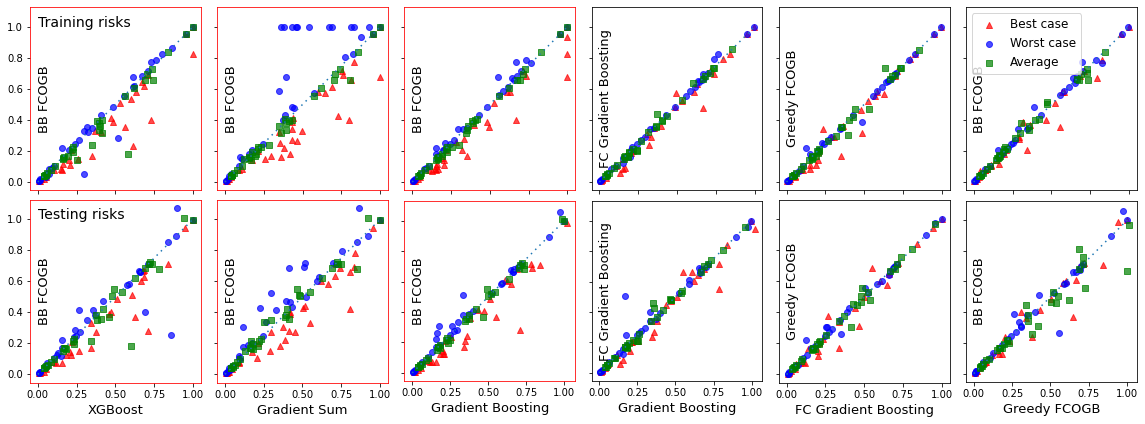

In [18]:
xs_bc_tr = [xobc_x_tr, sobc_s_tr, gobc_g_tr, gfbc_g_tr, fgbc_f_tr, gebc_g_tr, ]
ys_bc_tr = [xobc_o_tr, sobc_o_tr, gobc_o_tr, gfbc_f_tr, fgbc_g_tr, gebc_e_tr, ]
xs_avg_tr = [xoa_x_tr, soa_s_tr, goa_g_tr, gfa_g_tr, fga_f_tr, gea_g_tr, ]
ys_avg_tr = [xoa_o_tr, soa_o_tr, goa_o_tr, gfa_f_tr, fga_g_tr, gea_e_tr, ]
xs_wc_tr = [xowc_x_tr, sowc_s_tr, gowc_g_tr, gfwc_g_tr, fgwc_f_tr, gewc_g_tr, ]
ys_wc_tr = [xowc_o_tr, sowc_o_tr, gowc_o_tr, gfwc_f_tr, fgwc_g_tr, gewc_e_tr, ]
xs_bc_te = [xobc_x_te,sobc_s_te,  gobc_g_te, gfbc_g_te, fgbc_f_te, gebc_g_te, ]
ys_bc_te = [xobc_o_te, sobc_o_te, gobc_o_te, gfbc_f_te, fgbc_g_te, gebc_e_te, ]
xs_avg_te = [xoa_x_te, soa_s_te, goa_g_te, gfa_g_te, fga_f_te, gea_g_te, ]
ys_avg_te = [xoa_o_te, sxoa_o_te, goa_o_te, gfa_f_te, fga_g_te, gea_e_te, ]
xs_wc_te = [xowc_x_te, sowc_s_te, gowc_g_te, gfwc_g_te, fgwc_f_te, gewc_g_te, ]
ys_wc_te = [xowc_o_te, sowc_o_te, gowc_o_te, gfwc_f_te, fgwc_g_te, gewc_e_te, ]
xlabels=['XGBoost', 'Gradient Sum', 'Gradient Boosting', 'Gradient Boosting', 'FC Gradient Boosting', 'Greedy FCOGB']
ylabels=['BB FCOGB', 'BB FCOGB', 'BB FCOGB', 'FC Gradient Boosting', 'Greedy FCOGB', 'BB FCOGB']
fig, axs = plt.subplots(2, 6, figsize=(16,6), sharey=True, tight_layout=True, squeeze=False)
for i in range(2):
    for j in range(6):
        ax = axs[i, j]
        ax.set_aspect('equal', adjustable='box')
        if i==1:
            ax.set_xlabel(''+xlabels[j], fontsize=13)
        ax.set_ylabel(''+ylabels[j], fontsize=13)
        ax.yaxis.set_label_coords(0.12, 0.5)
        if j<3:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
        if i==0:
            ax.set_xticklabels([])
            ax.scatter(xs_bc_tr[j], ys_bc_tr[j], label='Best case', c='red', alpha=0.7, marker='^')
            ax.scatter(xs_wc_tr[j], ys_wc_tr[j], label='Worst case', c='blue', alpha=0.7,  marker='o')
            ax.scatter(xs_avg_tr[j], ys_avg_tr[j], label='Average', c='green', alpha=0.7, marker='s')
        if i==1:
            ax.scatter(xs_bc_te[j], ys_bc_te[j], label='Best case', c='red', alpha=0.7,marker='^')
            ax.scatter(xs_wc_te[j], ys_wc_te[j], label='Worst case', c='blue', alpha=0.7,  marker='o')
            ax.scatter(xs_avg_te[j], ys_avg_te[j], label='Average', c='green', alpha=0.7,  marker='s')
        ax.plot([0,1], [0,1], linestyle=(0, (1,3)))
axs[0,5].legend(fontsize=12)
axs[0, 0].text(0, 1, 'Training risks', fontsize=14)
axs[1, 0].text(0, 1, 'Testing risks', fontsize=14)
plt.show()
fig.savefig('1ablation_study.pdf') 